In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from IPython.display import HTML
from matplotlib import animation

%matplotlib inline

In [18]:
resdir1 = 'm-1ME_A-5e7/results/e0-0.10_t-100.0Myr_m0-1Me_p-99.5_r-10'
resdir2 = 'A_stg_5e7/results/e0-0.10_t-5.0Myr_m0-10Me_p-100_r-10'

t_tot = 10e6
gpe = 100  
gps = 80    
e0 = 0.10
m0 = 10 

A_stg = 5e7      # strength constant A in mJ (g m^2 / s^2)

def unpack(res,pand):
    if pand == True:
        N = pd.read_csv('%s/N.csv' %res, header=None,index_col=None)
        N_i = pd.read_csv('%s/N_i.csv' %res, header=None,index_col=None)
        N_o = pd.read_csv('%s/N_o.csv' %res, header=None,index_col=None)
        ts = pd.read_csv('%s/ts.csv' %res, header=None,index_col=None)
        dt = pd.read_csv('%s/dt.csv' %res, header=None,index_col=None)
        fu = pd.read_csv('%s/fu.csv' %res, header=None,index_col=None)
        
        ts = ts.to_numpy()
        fu = fu.to_numpy()
        dt = dt.to_numpy()
    else:
        N = np.load('%s/N.npy' %res)
        N_i = np.load('%s/N_i.npy' %res)
        N_o = np.load('%s/N_o.npy' %res)
        ts = np.load('%s/ts.npy' %res)
        dt = np.load('%s/dt.npy' %res)
        fu = np.load('%s/fu.npy' %res)

    steps_track = len(N)
    steps_integ = len(dt)
    print(res, 'took', steps_integ,'steps')
    
    if pand == True:
        N = N.to_numpy()
        N_i = N_i.to_numpy()
        N_o = N_o.to_numpy()
        
    N = N.reshape(steps_track,gpe,gps)
    N_i = N_i.reshape(steps_track,gpe,gps)
    N_o = N_o.reshape(steps_track,gpe,gps)

    Ndot = 10**N_i - 10**N_o

    return N, N_i, N_o, Ndot, ts, dt, fu

N1, N_i1, N_o1, Ndot1, ts1, dt1, fu1 = unpack(resdir1,False)
N2, N_i2, N_o2, Ndot2, ts2, dt2, fu2 = unpack(resdir2,False)

m-1ME_A-5e7/results/e0-0.10_t-100.0Myr_m0-1Me_p-99.5_r-10 took 8545 steps
A_stg_5e7/results/e0-0.10_t-5.0Myr_m0-10Me_p-100_r-10 took 7338 steps


In [19]:
sMin = -4    
sMax = 8

eMin = 0     
eMax = 0.2

size = np.linspace(sMin,sMax,gps)
eccs = np.linspace(eMin,eMax,gpe)

rho = 1
mass = np.log10(rho*1*np.pi/3) + 3*size  # log mass in g

asp_rat = (sMax-sMin)/(eMax-eMin)

B_stg = 3.3e-8    # strength constant B
s_small = 0            # size_0 of strength eq = 1 cm in log cm
alp_stg = -0.3    # strength constant alpha
bet_stg = 2       # strength constant beta

G = 4*np.pi**2
sma = 45                # semimajor axis in au
h = 1                   # disk scale height h = 1 AU
vkep = np.sqrt(G/sma) * (1.5e11/3.15e7)     # keplerian velocity in m s^-1

def qstar(s1):
    term1 = A_stg * (s1/s_small)**alp_stg
    term2 = B_stg * 2.5 * (s1/s_small)**bet_stg
    return term1 + term2
def efault(s):
    """
    - For a given size, defines the minimum e for which a catastrophic collision can occur
    - Assumes both body and bullet have same e
    - If e < efail, 2*Q_star > vcol**2 --> not enough energy to break up
    
    In: s -- float; size, in meters
    Out: efail -- float; min eccentricity
    """
    Q_ = qstar(s)/10000
    efail = np.sqrt(2*Q_)/vkep
    return efail

efail = efault(10**size)

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10216/627841949.py:26: RuntimeWarning: divide by zero encountered in true_divide
  term1 = A_stg * (s1/s_small)**alp_stg


In [20]:
def mass_cdf(numbers):
    """
    In: numbers -- 2D array; number of objects in each bin
    
    Out: cdf_mass -- 2D array; total mass of objects of lower ecc and smaller size than that bin
    """
    
    bin_mass = 10**(mass + numbers)
    cdf_mass = np.zeros_like(numbers)
    
    for i in range(gpe):
        for n in range(gps):
            cdf_mass[i,n] = np.sum( bin_mass[:i+1,:n+1] )

    return cdf_mass

def integrate_mass(sizes,numbers,comp='earth'):
    """
    In: sizes -- array; sizes of each bin, in log cm
        numbers -- array; number of objects in each bin
        comp -- string ['earth','jupiter','pluto']; planet to compare total mass to
        
    Out: mtot -- float; total mass in disk, in earth masses
    """
    mass = (4*np.pi/3) * rho * (10**sizes)**3
    
    dm_ = mass[1:] - mass[:-1]
    mbin = (10**numbers[1:] + 10**numbers[:-1])/2
    
    mtot_g = np.nansum(mbin*dm_)

    if comp == 'earth':
        mtot = mtot_g/5.972e27
    elif comp == 'pluto':
        mtot = mtot_g/1.309e25
    elif comp == 'jupiter':
        mtot = mtot_g/1.899e30
    else:
        print('check your comparison name')
        return
        
    return mtot

def total_mass_at_each_step(N):
    steps = len(N)
    total_mass_ts = np.zeros(steps)
    for i in range(steps):
        s_nums_t = np.sum(10**N[i],axis=0)
        total_mass_ts[i] = integrate_mass(size, np.log10(s_nums_t), 'earth')
        
    return total_mass_ts

def integration_times(dt):
    ts = np.zeros(len(dt))
    for i in range(len(dt)):
        ts[i] = np.sum(dt[:i])
        
    return ts

def difference(n1, n2):  
    N_1 = 10**n1
    N_2 = 10**n2
    
    diff = (N_1 - N_2)/N_1
    absdiff = np.abs(N_1 - N_2)/N_1
    avg = np.nanmean(np.nan_to_num(absdiff,posinf=np.nan,neginf=np.nan))
    med = np.nanmedian(absdiff)
    std = np.nanstd(absdiff)
    
    return diff, avg, med, std

In [21]:
total_mass_ts1 = total_mass_at_each_step(N1)
total_mass_ts2 = total_mass_at_each_step(N2)

int_times_1 = integration_times(dt1)
int_times_2 = integration_times(dt2)

diff = np.zeros((len(N1),gpe,gps))
davg = np.zeros(len(N1))
dmed = np.zeros(len(N1))
dstd = np.zeros(len(N1))

for i in range(len(N1)):
    diff[i], davg[i], dmed[i], dstd[i] = difference(N1[i],N2[i])

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10216/3060025294.py:64: RuntimeWarning: invalid value encountered in true_divide
  diff = (N_1 - N_2)/N_1
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10216/3060025294.py:64: RuntimeWarning: divide by zero encountered in true_divide
  diff = (N_1 - N_2)/N_1
/Users/mdodici/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


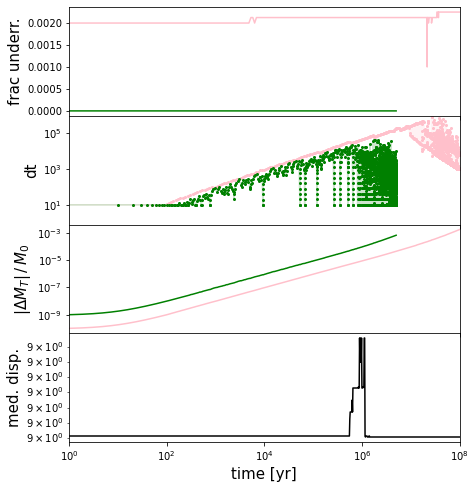

In [22]:
fig,ax=plt.subplots(4,figsize=(7,8),sharex=True)

ax[0].plot(int_times_1, fu1,c='pink')
ax[0].plot(int_times_2, fu2,c='g')
#ax[0].set_ylim(-1e-3,.8e-2)
ax[0].set_ylabel('frac underr.',fontsize=15)

ax[1].plot(int_times_1 ,dt1,ls='-',marker='',markersize=2,c='pink',alpha=.2)
ax[1].plot(int_times_2 ,dt2,ls='-',marker='',markersize=2,c='g',alpha=.2)
ax[1].plot(int_times_1 ,dt1,ls='',marker='o',markersize=2,c='pink')
ax[1].plot(int_times_2 ,dt2,ls='',marker='o',markersize=2,c='g')
ax[1].set_ylabel('dt',fontsize=15)
ax[1].set_ylim(1-.2*1,max(np.append(dt1,dt2))+.2*max(np.append(dt1,dt2)))

ax[2].plot(ts1 , (total_mass_ts1 - total_mass_ts1[0]) / total_mass_ts1[0],ls='-', marker='',markersize=2,c='pink')
ax[2].plot(ts1 ,-(total_mass_ts1 - total_mass_ts1[0]) / total_mass_ts1[0],ls='--',marker='',markersize=2,c='pink')
ax[2].plot(ts2 , (total_mass_ts2 - total_mass_ts2[0]) / total_mass_ts2[0],ls='-', marker='',markersize=2,c='g')
ax[2].plot(ts2 ,-(total_mass_ts2 - total_mass_ts2[0]) / total_mass_ts2[0],ls='--',marker='',markersize=2,c='g')
ax[2].set_ylabel(r'$|\Delta M_T| \,/\,M_{0}$',fontsize=15)

ax[3].plot(ts1,dmed,'k')
ax[3].set_ylabel('med. disp.',fontsize=15)

for i in range(3):
    ax[i+1].set_yscale('log')

plt.subplots_adjust(hspace=0)
plt.xlim(1,ts1[-1])
plt.xscale('log')
plt.xlabel('time [yr]',fontsize=15)

#fig.tight_layout()
plt.show()

In [13]:
"""fig, ax = plt.subplots(figsize=(6,5))
ax.set_ylim(eMin,eMax)
ax.set_xlim(sMin,sMax)
ax.set_xlabel('log size [cm]',fontsize=16)
ax.set_ylabel('eccentricity',fontsize=16)
ax.set_xlim(sMin,sMax)
ax.set_ylim(eMin,eMax)

txt_title = ax.set_title('')

im1 = ax.imshow(diff[0],origin='lower',extent=(sMin,sMax,eMin,eMax),aspect=asp_rat,cmap='PiYG_r',vmin=-3,vmax=3)
ax.plot(size,efail,c='k')

plt.colorbar(im1,ax=ax,label=r'disparity $|N_{perf} - N_{test}|\,/\,N_{perf}$')

def plot_flow(step):
    ax.clear()
    ax.imshow(diff[step],origin='lower',extent=(sMin,sMax,eMin,eMax),aspect=asp_rat,cmap='PiYG_r',vmin=-3,vmax=3)
    ax.set_title(r't = %.4f Myr' %(ts1[step]/1e6),fontsize=16)
    ax.plot(size,efail,c='k')
    plt.xlim(sMin,sMax)
    plt.ylim(eMin,eMax)
    
N_ratio_anim = animation.FuncAnimation(fig, plot_flow, frames=np.arange(len(diff))[::5], interval=100)
HTML(N_ratio_anim.to_html5_video())"""
print()

When a cell is pink, $N^{i,j}_\text{perfect} > N^{i,j}_\text{test}$, and when green, the opposite.

In [23]:
def opacity(numbers=N1, step='all'):
    """
    calculate opacity at a certain step of an evolution of our numbers array
    
    In: numbers -- ts-by-gpe-by-gps array; 3D array with numbers in each 2D bin at each timestep
        step -- 'all' or int; either all the timesteps or a particular one
        
    Out: opacity -- float or array; opacity at selected timesteps
    """
    if step == 'all':
        opacity = np.zeros(len(numbers))
        for t in range(len(numbers)):
            for i, e in enumerate(eccs):
                N_sizes = 10**numbers[t,i]
                h = 2 * e * sma
                N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))
                opacity[t] += np.nansum(N_scale)
    else:
        N_sizes = np.nansum(10**numbers[step],axis=0)
        N_scale = N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2)
        opacity = np.nansum(N_scale)
        
    return opacity

def mass_size_bins(numbers,bins=4,step='all'):
    
    bin_edges = np.linspace(0,(numbers.shape)[2],bins+1,dtype=int)
    if step == 'all':
        bin_mass = np.zeros((bins,len(numbers)))
        for t in range(len(numbers)):
            N_sizes = np.nansum(10**numbers[t],axis=0)
            M_sizes = N_sizes * (4*np.pi/3) * 10**(size*3)
            for i in range(bins):
                lo = bin_edges[i]
                hi = bin_edges[i+1]
                bin_mass[i,t] = np.nansum(M_sizes[lo:hi])
    return bin_mass       

def mass_eccs_bins(numbers,bins,eccs,eMin,eMax,step='all'):
    
    ecc_edges = np.linspace(eMin,eMax,bins+1)
    bin_edges = np.zeros(bins+1)
    for i in range(bins+1):
        bin_edges[i] = np.argmin(abs(ecc_edges[i] - eccs))
    if step == 'all':
        bin_mass = np.zeros((bins,len(numbers)))
        for t in range(len(numbers)):
            M_dist = 10**numbers[t] * (4*np.pi/3) * 10**(size*3)
            M_eccs = np.nansum(M_dist,axis=1)
            for i in range(bins):
                lo = bin_edges[i].astype(int)
                hi = bin_edges[i+1].astype(int)
                bin_mass[i,t] = np.nansum(M_eccs[lo:hi])
    return bin_mass    

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10216/3176980317.py:16: RuntimeWarning: invalid value encountered in true_divide
  N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10216/3176980317.py:16: RuntimeWarning: invalid value encountered in true_divide
  N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))


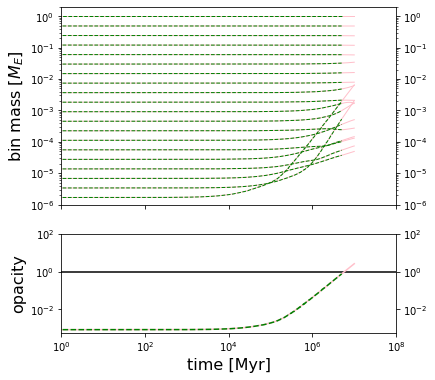

In [26]:
fig,ax = plt.subplots(2,figsize=(6,6),sharex=True,gridspec_kw={'height_ratios': [2, 1]})
ax[0].plot(ts1/10,(mass_size_bins(N1,bins=80)/5.96e27)[::4].T*10, c='pink',lw=1)
ax[0].plot(ts2,(mass_size_bins(N2,bins=80)/5.96e27)[::4].T, 'g--',lw=1)
ax[0].set_xlim(1,ts1[-1])
#ax[0].legend([r'$\mu$m$-$mm', r'mm$-$m',r'm$-$km',r'km$+$'])
ax[0].set_ylabel(r'bin mass [$M_E$]',fontsize=16)
    
ax[1].plot(ts1/10,opacity(N1)*10,c='pink')
ax[1].plot(ts2,opacity(N2),'g--')
ax[1].hlines(1,1e-6,1e10,color='k',zorder=0)
ax[1].set_xlim(1,ts1[-1])
ax[1].set_ylabel('opacity',fontsize=16)
ax[1].set_xlabel('time [Myr]',fontsize=16)

for i in range(2):
    ax[i].tick_params('y',which='both',right=True,labelright=True)
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')

ax[1].set_yticks([.01,1,100])

ax[0].set_ylim(1e-6,2e0)
#ax[1].set_ylim(1e-3,1e3)

plt.show()
#fig.savefig('mass_opacity_evo.png',dpi=300)

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10216/3176980317.py:16: RuntimeWarning: invalid value encountered in true_divide
  N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10216/3176980317.py:16: RuntimeWarning: invalid value encountered in true_divide
  N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))


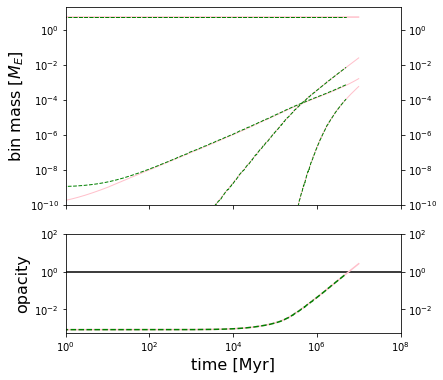

In [27]:
fig,ax = plt.subplots(2,figsize=(6,6),sharex=True,gridspec_kw={'height_ratios': [2, 1]})
ax[0].plot(ts1/10,(mass_eccs_bins(N1,6,np.linspace(0,.20,100),.00,.12)/5.96e27).T*10, c='pink',lw=1)
ax[0].plot(ts2,(mass_eccs_bins(N2,6,np.linspace(0,.20,100),.00,.12)/5.96e27).T, 'g--',lw=1)
ax[0].set_xlim(1,ts1[-1])
#ax[0].legend([r'$\mu$m$-$mm', r'mm$-$m',r'm$-$km',r'km$+$'])
ax[0].set_ylabel(r'bin mass [$M_E$]',fontsize=16)
    
ax[1].plot(ts1/10,opacity(N1)*10,c='pink')
ax[1].plot(ts2,opacity(N2),'g--')
ax[1].hlines(1,1e-6,1e10,color='k',zorder=0)
ax[1].set_xlim(1,ts1[-1])
ax[1].set_ylabel('opacity',fontsize=16)
ax[1].set_xlabel('time [Myr]',fontsize=16)

for i in range(2):
    ax[i].tick_params('y',which='both',right=True,labelright=True)
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')

ax[1].set_yticks([.01,1,100])

ax[0].set_ylim(1e-10,20)
#ax[1].set_ylim(1e-3,1e3)

plt.show()
#fig.savefig('mass_opacity_evo.png',dpi=300)